In [7]:
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [233]:
def add_scale_bar(ax, length=100, location=(0, 0), linewidth=5, units='km', text=True):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker
    import numpy as np

    extent = ax.get_extent(crs=ccrs.PlateCarree())
    map_width_deg = extent[1] - extent[0]

    mid_lat = (extent[2] + extent[3]) / 2

    km_per_deg_at_lat = np.cos(np.radians(mid_lat)) * 111.32

    map_width_km = map_width_deg * km_per_deg_at_lat

    scale_bar_length_deg = (length / map_width_km) * map_width_deg
    
    x_start = location[0] * map_width_deg + extent[0]
    x_end = x_start + scale_bar_length_deg
    y_position = location[1] * (extent[3] - extent[2]) + extent[2]

    ax.plot([x_start, x_end], [y_position, y_position], transform=ccrs.PlateCarree(), color='k', linewidth=linewidth, zorder=4)
    
    if text==True:
        ax.text(x_end, y_position, ' '+f'{length} {units}', verticalalignment='bottom', horizontalalignment='left', transform=ccrs.Geodetic(), fontsize=10)

(-131.53, -61.46, 24.09, 54.9)

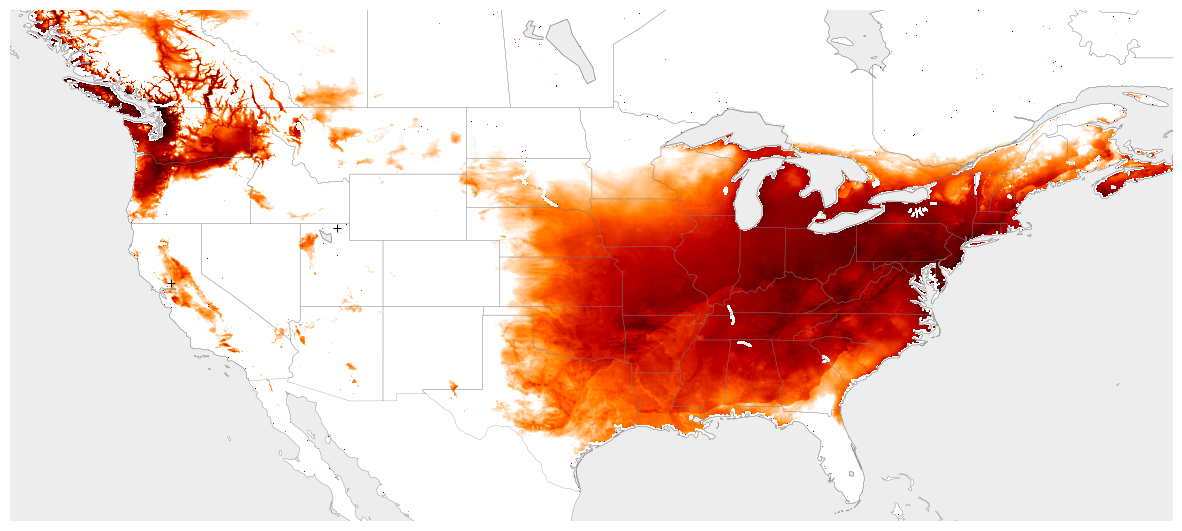

In [109]:
from matplotlib.colors import Normalize

extent = [-131.53, -61.46, 24.09, 54.90]

cities = {'logan': [41.73530959506221, -111.837716001538],
          'dixon': [38.44453457025947, -121.82173075314377]}

map_projection = ccrs.PlateCarree()
# shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
# gdf = gpd.read_file(shapefile_path)
# gdf = gdf.to_crs(map_projection.proj4_init)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)
great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')


with rasterio.open('data/rasters/distance_raster_temp.tif') as src:
    raster = src.read(1)


fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  

min_value = 0  
max_value = 64 

norm = Normalize(vmin=min_value, vmax=max_value)
cmap = plt.get_cmap('gist_heat')
cmap.set_bad(color='white') 
cmap.set_under((1, 1, 1, 0))
cmap.set_over((1, 1, 1, 0))


img = plt.imshow(raster, cmap=cmap, norm=norm, extent=extent, transform=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, facecolor='#DBDBDB', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(cfeature.STATES, linewidth=.2, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

    

for city in cities.values():
    ax.scatter(city[1], city[0], transform=ccrs.PlateCarree(), s=40, c='k', marker="+", lw=0.7)

ax.axis('off')

# add_scale_bar(ax, 500, location=(0, 0), linewidth=5, units='km', text=False)

# plt.savefig('figures/maps/similarity_map.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)

(-131.53, -61.46, 24.09, 54.9)

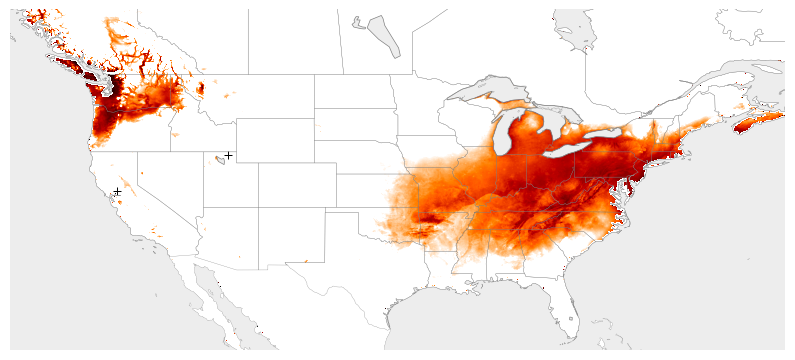

In [120]:
with rasterio.open('data/rasters/distance_raster_all_vars_redo.tif') as src:
    raster = src.read(1)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  

min_value = 0  
max_value = 28.6

norm = Normalize(vmin=min_value, vmax=max_value)
cmap = plt.get_cmap('gist_heat')
cmap.set_bad(color='white') 
cmap.set_under((1, 1, 1, 0))
cmap.set_over((1, 1, 1, 0))


# img = plt.imshow(raster, cmap=cmap, norm=norm, extent=extent, transform=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, facecolor='#DBDBDB', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(cfeature.STATES, linewidth=.2, zorder=2, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

img = plt.imshow(raster, cmap=cmap, norm=norm, extent=extent, transform=ccrs.PlateCarree())
    

for city in cities.values():
    ax.scatter(city[1], city[0], transform=ccrs.PlateCarree(), s=40, c='k', marker="+", lw=0.7)

ax.axis('off')


In [204]:
import cartopy.io.shapereader as shpreader
from rasterio.crs import CRS
from rasterio.enums import Resampling

output_raster = 'data/rasters/corrected_crs_raster.tif'

with rasterio.open('data/rasters/distance_raster_all_vars_redo.tif') as src:
    new_crs = CRS.from_epsg(4326) 
    metadata = src.meta.copy()
    metadata.update({'crs': new_crs})

    data = src.read(
        out_shape=(
            src.count,
            int(src.height),
            int(src.width)
        ),
        resampling=Resampling.nearest
    )

    # Write the raster with the new CRS
    with rasterio.open(output_raster, 'w', **metadata) as dst:
        dst.write(data)

# Confirm the change
with rasterio.open(output_raster) as src:
    print("Updated CRS:", src.crs)
    raster = src.read(1)

Updated CRS: EPSG:4326


In [253]:
import json

with open('./data/eur_distances.json', 'r') as file:
    eur_distances = json.load(file)

In [262]:
np.mean(eur_distances)

3.999380915558305

(array([1.364e+03, 2.119e+03, 7.400e+02, 4.860e+02, 3.620e+02, 2.730e+02,
        1.870e+02, 1.310e+02, 9.600e+01, 7.600e+01, 7.400e+01, 7.500e+01,
        7.900e+01, 4.300e+01, 4.800e+01, 5.100e+01, 4.800e+01, 1.500e+01,
        2.100e+01, 2.000e+01, 1.300e+01, 8.000e+00, 1.000e+01, 1.100e+01,
        7.000e+00, 1.700e+01, 1.200e+01, 1.100e+01, 6.000e+00, 5.000e+00,
        7.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

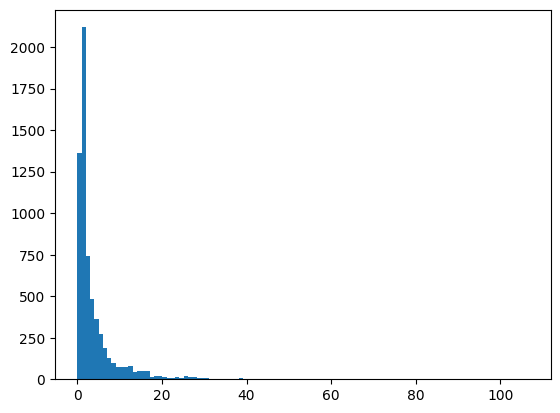

In [265]:
plt.hist(eur_distances, bins=106)

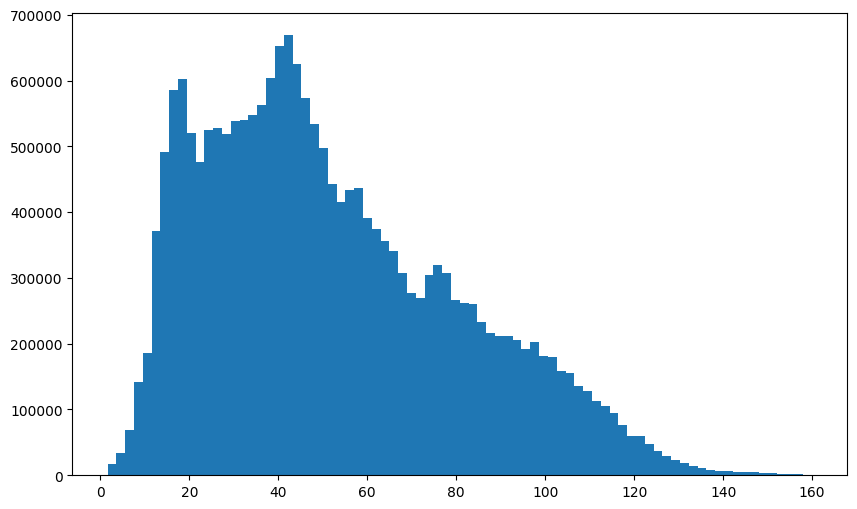

In [266]:
import numpy as np

with rasterio.open(output_raster) as src:
    band = src.read(1)
    masked_band = np.ma.masked_where(band == src.nodata, band)
    hist, bin_edges = np.histogram(masked_band.compressed(), bins=80, range=(np.min(masked_band), 160))
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
    

In [268]:
np.mean(masked_band.compressed())

52.0479

EPSG:4326


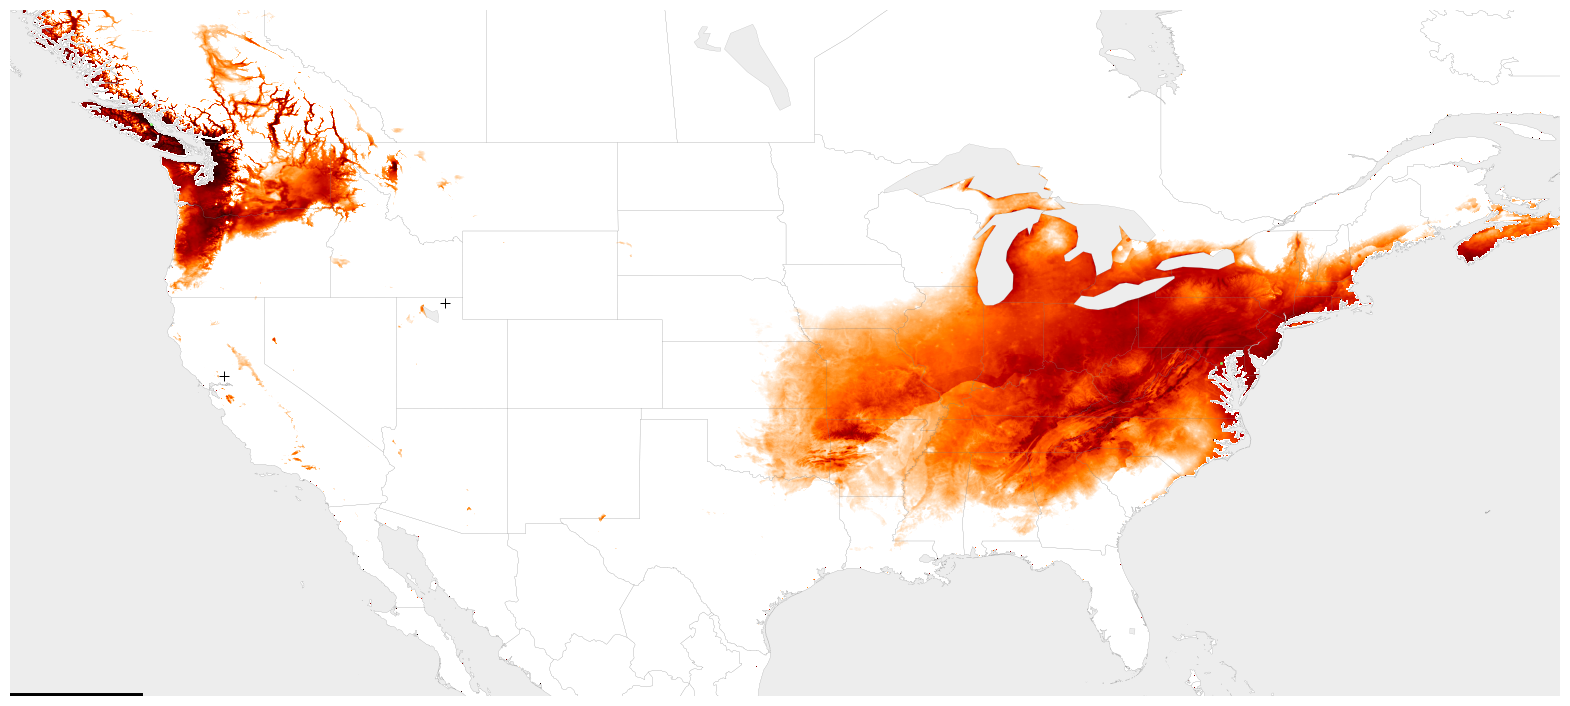

In [237]:
print(src.crs)

extent = [-131.5, -61.5, 24, 55]

min_value = 0  
max_value = 28.6

norm = Normalize(vmin=min_value, vmax=max_value)
cmap = plt.get_cmap('gist_heat')
cmap.set_bad(color='white') 
cmap.set_under((1, 1, 1, 0))
cmap.set_over((1, 1, 1, 0))

ocean_shp = shpreader.natural_earth(resolution='10m', category='physical', name='ocean')
reader_ocean = shpreader.Reader(ocean_shp)
oceans = list(reader_ocean.geometries())

lake_shp = shpreader.natural_earth(resolution='110m', category='physical', name='lakes')
reader_lakes = shpreader.Reader(lake_shp)
lakes = list(reader_lakes.geometries())

states_shp = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
reader = shpreader.Reader(states_shp)
states = list(reader.geometries())

fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent, crs=ccrs.PlateCarree())  
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='gray', linewidth=.1, facecolor='none', zorder=2)
ax.add_geometries(oceans, ccrs.PlateCarree(), facecolor='#ededed',linewidth=.1, zorder=3, edgecolor='gray')
ax.add_geometries(lakes, ccrs.PlateCarree(), edgecolor='gray', linewidth=.1, facecolor='#ededed', zorder=2)

img = plt.imshow(raster, cmap=cmap, norm=norm, extent=extent, transform=ccrs.PlateCarree())

for city in cities.values():
    ax.scatter(city[1], city[0], transform=ccrs.PlateCarree(), s=50, c='k', marker="+", lw=0.7)

cocoon_point = [49.83620009066017, -125.12898486096769]
ax.scatter(cocoon_point[1], cocoon_point[0], transform=ccrs.PlateCarree(), s=10, facecolor='#88ff70', edgecolor=None, marker=".", lw=0.5)

taurus_point = [39.0494, -76.8198]
ax.scatter(taurus_point[1], taurus_point[0], transform=ccrs.PlateCarree(), s=10, facecolor='#88ff70', edgecolor=None, marker=".", lw=0.5)


# cbar = plt.colorbar(fraction=0.02, pad=0.04)

ax.axis('off')

add_scale_bar(ax, 500, location=(0, 0), linewidth=5, units='km', text=False)

# plt.savefig('figures/maps/raster_map.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('figures/maps/raster_map_scale.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0)

(-131.53, -61.46, 24.09, 54.9)

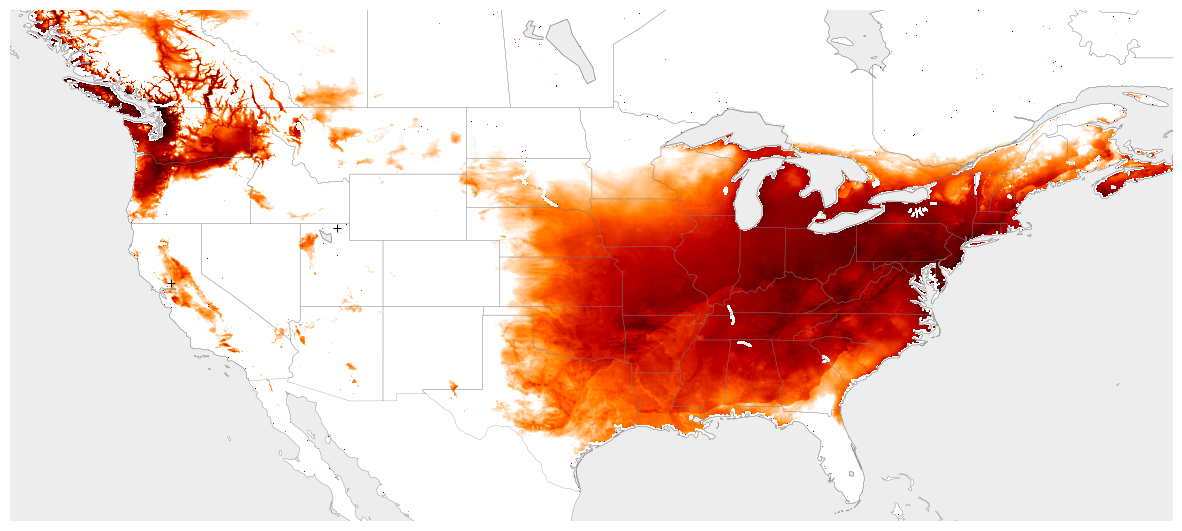

In [ ]:
from matplotlib.colors import Normalize

extent = [-131.53, -61.46, 24.09, 54.90]

cities = {'logan': [41.73530959506221, -111.837716001538],
          'dixon': [38.44453457025947, -121.82173075314377]}

map_projection = ccrs.PlateCarree()
# shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
# gdf = gpd.read_file(shapefile_path)
# gdf = gdf.to_crs(map_projection.proj4_init)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)
great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')


with rasterio.open('data/rasters/distance_raster_temp.tif') as src:
    raster = src.read(1)


fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  

min_value = 0  
max_value = 64 

norm = Normalize(vmin=min_value, vmax=max_value)
cmap = plt.get_cmap('gist_heat')
cmap.set_bad(color='white') 
cmap.set_under((1, 1, 1, 0))
cmap.set_over((1, 1, 1, 0))


img = plt.imshow(raster, cmap=cmap, norm=norm, extent=extent, transform=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, facecolor='#DBDBDB', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(cfeature.STATES, linewidth=.2, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

    

for city in cities.values():
    ax.scatter(city[1], city[0], transform=ccrs.PlateCarree(), s=40, c='k', marker="+", lw=0.7)

ax.axis('off')

# add_scale_bar(ax, 500, location=(0, 0), linewidth=5, units='km', text=False)

# plt.savefig('figures/maps/similarity_map.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)